## Libraries and Dependencies

In [ ]:
!pip install pandas
!pip install numpy
!pip install transformers
!pip install torch torchvision

# install the sentencepiece library
# NOTE: if installing for the first time and if using google colab, restart the runtime after installation
!pip install sentencepiece

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt
import random
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import RandomSampler, SequentialSampler, TensorDataset, DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer, BertForSequenceClassification, BertTokenizer,AdamW
from transformers import DebertaForSequenceClassification, AlbertForSequenceClassification, ElectraForSequenceClassification
from transformers import DebertaTokenizer, AlbertTokenizer, ElectraTokenizer
from sklearn.metrics import f1_score, classification_report

## Pre-trained Models

In [ ]:
# Use GPU if available else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# import the pre-trained models
modelB = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
modelR = RobertaForSequenceClassification.from_pretrained("roberta-base").to(device)
modelE = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator").to(device)
modelA = AlbertForSequenceClassification.from_pretrained("albert-base-v2").to(device)
modelD = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base").to(device)

# Tokenizers to be used
tokenizerB = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizerR = RobertaTokenizer.from_pretrained("roberta-base")
tokenizerE = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")
tokenizerA = AlbertTokenizer.from_pretrained("albert-base-v2")
tokenizerD = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

print("Model ready to be fine-tuned!!!")

## Data Loading

In [ ]:
def loadAugmentedData():

  trainData = pd.read_json("./Augmented_train.jsonl", lines=True, orient="records")
  valData = pd.read_json("./Augmented_val.jsonl", lines=True, orient="records")
  
  # Train 
  trainPassages = trainData.passage.values
  trainQuestions = trainData.question.values
  trainAnswers = trainData.label.values

  # Validation
  valPassages = valData.passage.values
  valQuestions = valData.question.values
  valAnswers = valData.label.values

  return trainQuestions, trainPassages, trainAnswers, valQuestions, valPassages, valAnswers

trainQuestions, trainPassages, trainAnswers, valQuestions, valPassages, valAnswers = loadAugmentedData()

## Tokenization

In [ ]:
def tokenizeData(tokenizer, questions, passages, max_length=256):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
      tokenizedData = tokenizer.encode_plus(question, passage, max_length=max_length, padding='max_length', truncation="longest_first")
      tokenizedQP = tokenizedData["input_ids"]
      attentionMask = tokenizedData["attention_mask"]

      input_ids.append(tokenizedQP)
      attention_masks.append(attentionMask)

    return np.array(input_ids), np.array(attention_masks)


## Building Dataloaders

In [ ]:
# Building the Dataloaders

def buildDataLoaders(batchSize, trainFeatures, valFeatures):
  trainTensors = [torch.tensor(feature, dtype=torch.long) for feature in trainFeatures]
  valTensors = [torch.tensor(feature, dtype=torch.long) for feature in valFeatures]

  trainDataset = TensorDataset(*trainTensors)
  valDataset = TensorDataset(*valTensors)

  trainSampler = RandomSampler(trainDataset)
  valSampler = SequentialSampler(valDataset)

  trainDataloader = DataLoader(trainDataset, sampler=trainSampler, batch_size=batchSize)
  valDataloader = DataLoader(valDataset, sampler=valSampler, batch_size=batchSize)

  return trainDataloader, valDataloader

## Training & Model Saving

In [ ]:
# Fine-tune the model on downstream task: BoolQ
def train(numEpochs, gradSteps, model, optimizer, trainDataLoader, runType="regular"):
    
  trainLossHistory = []

  for _ in tqdm(range(numEpochs), desc="Training Epoch's"):

    # Train the model for fine-tuning
    epochTrainLoss = 0 # Cumulative loss
    model.train()
    model.zero_grad()

    for step, batch in enumerate(trainDataLoader):
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)     
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / gradSteps
        epochTrainLoss += loss.item()
        loss.backward()
        
        if (step + 1) % gradSteps == 0: # Gradient accumulation is over
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
          optimizer.step()
          model.zero_grad()

    epochTrainLoss = epochTrainLoss / len(trainDataLoader)          
    trainLossHistory.append(epochTrainLoss)

  saveModel(model, runType)

  sns.set()
  plt.plot(trainLossHistory, label="Train_Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss")
  plt.legend()
  plt.xticks(np.arange(0, 3))
  plt.show()

def saveModel(model, runType):

  if not os.path.exists("./models/"):
    os.mkdir("./models/")
  
  if not os.path.exists("./models/" + runType + "/"):
    os.mkdir("./models/" + runType + "/")

  if model == modelB:
    modelName = "/bert.pt"
  elif model == modelR:
    modelName = "/roberta.pt"
  elif model == modelE:
    modelName = "/electra.pt"
  elif model == modelA:
    modelName = "/albert.pt"
  elif model == modelD:
    modelName = "/deberta.pt"

  torch.save(model, "./models/" + runType + modelName)


## Evaluation

In [ ]:
# Evaluation on validation set
def eval(valDataLoader, numEpochs, model):
    valAccuracy = []
    valF1 = []

    for _ in tqdm(range(numEpochs), desc="Validation Epoch's"):
      epochValAcc = 0
      epochValF1 = 0
      model.eval()
      for batch in valDataLoader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]
                    
        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        epochValF1 += f1_score(predictions, labels)
        epochValAcc += np.sum(predictions == labels) / len(labels)

      epochValAcc = epochValAcc / len(valDataLoader)
      epochValF1 = epochValF1 / len(valDataLoader)
      valAccuracy.append(epochValAcc)
      valF1.append(epochValF1)

    acc = sum(valAccuracy) / len(valAccuracy)
    f1 = sum(valF1) / len(valF1)
    print("\nVal Accuracy:", acc)
    print("Val F1:", f1)

    
    plt.plot(valAccuracy, label="Val_Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy")
    plt.legend()
    plt.xticks(np.arange(0, 3))
    plt.show()

    return acc, f1

## Predictions

In [ ]:
# Making Predictions on the test set
def predict(question, passage, max_length=512):
  sequence = tokenizer.encode_plus(question, passage, max_length=max_length,
                                   padding='max_length', truncation="longest_first" 
                                   , return_tensors="pt")['input_ids'].to(device)
  
  logits = model(sequence)[0]
  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
  proba_yes = round(probabilities[1], 2)
  proba_no = round(probabilities[0], 2)
  return (f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")

# for i in range(len(testPassages)):
#   testPred.write(f"\n{i}" + ": " + predict(testQuestions[i], testPassages[i]))
  



## Fine-tune and Evaluate

In [ ]:
def runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType="Regular"):

  print("Fine-tuning and evaluating the model...")
  # Tokenize the data
  trainIds, trainAttMasks = tokenizeData(tokenizer, trainQuestions, trainPassages, maxSeqLength)
  valIds, valAttMasks = tokenizeData(tokenizer, valQuestions, valPassages, maxSeqLength)
  # testIds, testAttMasks = tokenizeData(tokenizer, testQuestions, testPassages, maxSeqLength)

  trainFeatures = (trainIds, trainAttMasks , trainAnswers)
  valFeatures = (valIds, valAttMasks, valAnswers)
  # testFeatures = (testIds, testAttMasks)

  # Build the Dataloaders
  trainDataLoader, valDataLoader = buildDataLoaders(batchSize, trainFeatures, valFeatures)

  # Fine-tune
  train(numEpochs, gradSteps, model, optimizer, trainDataLoader, runType)

  # Evaluate
  acc, f1 = eval(valDataLoader, numEpochs, model)

  # Writing results to a file
  if model == modelB:
    results = "resultsBERT.txt"
  elif model == modelR:
    results = "resultRoBERTa.txt" 
  elif model == modelE:
    results = "resultELECTRA.txt"
  elif model == modelA:
    results = "resultALBERT.txt"
  elif model == modelD:
    results = "resultDeBERTa.txt"
  
  resultFile = open(results, "w")
  resultFile.write(f"Validation Accuracy: {round(acc, 2)}, Validation F1: {round(f1,2)}")



## Load & Evaluate

In [ ]:
def loadModel(model, tokenizer, batchSize, learningRate, numEpochs, maxSeqLength, modelName = ""):

  print("Loading saved models for evaluation...")
  # Tokenize the data
  trainIds, trainAttMasks = tokenizeData(tokenizer, trainQuestions, trainPassages, maxSeqLength)
  valIds, valAttMasks = tokenizeData(tokenizer, valQuestions, valPassages, maxSeqLength)
  # testIds, testAttMasks = tokenizeData(tokenizer, testQuestions, testPassages, maxSeqLength)

  trainFeatures = (trainIds, trainAttMasks , trainAnswers)
  valFeatures = (valIds, valAttMasks, valAnswers)
  # testFeatures = (testIds, testAttMasks)

  # Build the Dataloaders
  trainDataLoader, valDataLoader = buildDataLoaders(batchSize, trainFeatures, valFeatures)

  # Evaluate
  acc, f1 = eval(valDataLoader, numEpochs, model)

  # Writing results to a file
  results = "result" + modelName + ".txt"
  
  resultFile = open(results, "w")
  resultFile.write(f"Validation Accuracy: {round(acc, 2)}, Validation F1: {round(f1,2)}")



### Running models

In [ ]:
def runBERT(model, tokenizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning BERT model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runROBERTA(model, tokenizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning RoBERTa model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runELECTRA(model, tokenizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning ELECTRA model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runALBERT(model, tokenizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning ALBERT model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runDEBERTA(model, tokenizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning DeBERTa model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runAll(batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  
  print("\nYou have selected to run all models")

  runBERT(modelB, tokenizerB, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)
  runROBERTA(modelR, tokenizerR, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)
  runELECTRA(modelE, tokenizerE, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)
  runALBERT(modelA, tokenizerA, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)
  runDEBERTA(modelD, tokenizerD, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)
  

### Loading models

In [ ]:
def loadBERT(batchSize, learningRate, numEpochs, runType, maxSeqLength):
  print("\nLoading and evaluating BERT model")
  model = torch.load("./models/" + runType + "/bert.pt")
  loadModel(model, tokenizerB, batchSize, numEpochs, maxSeqLength, "BERT")

def loadROBERTA(batchSize, learningRate, numEpochs, runType, maxSeqLength):
  print("\nLoading and evaluating RoBERTa model")
  model = torch.load("./models/" + runType + "/roberta.pt")
  loadModel(model, tokenizerR, batchSize, learningRate, numEpochs, maxSeqLength, "ROBERTA")

def loadELECTRA(batchSize, learningRate, numEpochs, runType, maxSeqLength):
  print("\nLoading and evaluating ELECTRA model")
  model = torch.load("./models/" + runType + "/electra.pt")
  loadModel(model, tokenizerE, batchSize, learningRate, numEpochs, maxSeqLength, "ELECTRA")

def loadALBERT(batchSize, learningRate, numEpochs, runType, maxSeqLength):
  print("\nLoading and evaluating ALBERT model")
  model = torch.load("./models/" + runType + "/albert.pt")
  loadModel(model, tokenizerA, batchSize, learningRate, numEpochs, maxSeqLength, "ALBERT")

def loadDEBERTA(batchSize, learningRate, numEpochs, runType, maxSeqLength):
  print("\nLoading and evaluating DeBERTa model")
  model = torch.load("./models/" + runType + "/deberta.pt")
  loadModel(model, tokenizerD, batchSize, learningRate, numEpochs, maxSeqLength, "DEBERTA")

def loadAll(batchSize, learningRate, numEpochs, runType, maxSeqLength):
  print("You have selected to load all the models and evaluate them.")
  loadBERT(batchSize, learningRate, numEpochs, runType, maxSeqLength)
  loadROBERTA(batchSize, learningRate, numEpochs, runType, maxSeqLength)
  loadELECTRA(batchSize, learningRate, numEpochs, runType, maxSeqLength)
  loadALBERT(batchSize, learningRate, numEpochs, runType, maxSeqLength)
  loadDEBERTA(batchSize, learningRate, numEpochs, runType, maxSeqLength)



# Testing

Models Available:
 1: BERT 
 2: RoBERTa 
 3: ELECTRA 
 4: ALBERT 
 5: DeBERTa 
 6: All

Select the model you'd like to run:5

What would you like to do: 

1: Fine-Tune and Evaluate 
2: Load and Evaluate:
1
Please enter a learning rate:(e.g. 1e-5)1e-5
Please enter batch size:(e.g. 8)8
Please enter the number of epochs:(e.g. 3)3
Please enter the maximum sequence length:(e.g. 128)128
Please enter the number of gradient steps:(e.g. 3)3
Please input the run type: (e.g. augDhawal)augDhawal

Running DeBERTa model
Fine-tuning and evaluating the model...


Training Epoch's: 100%|██████████| 3/3 [15:28<00:00, 309.35s/it]


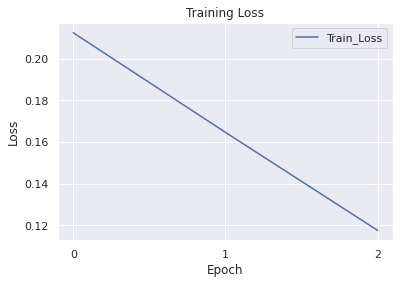

Validation Epoch's: 100%|██████████| 3/3 [01:47<00:00, 35.95s/it]


Val Accuracy: 0.7991400491400492
Val F1: 0.8259258077439912


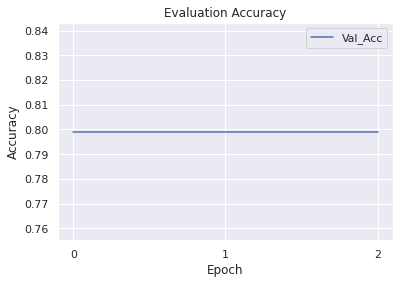

In [ ]:
print("Models Available:\n 1: BERT \n 2: RoBERTa \n 3: ELECTRA \n 4: ALBERT \n 5: DeBERTa \n 6: All\n")

choice = int(input("Select the model you'd like to run:"))

print("\nWhat would you like to do: \n")
choice2 = int(input("1: Fine-Tune and Evaluate \n2: Load and Evaluate:\n"))

learningRate = float(input("Please enter a learning rate:(e.g. 1e-5)"))
batchSize = int(input("Please enter batch size:(e.g. 8)"))
numEpochs = int(input("Please enter the number of epochs:(e.g. 3)"))
maxSeqLength = int(input("Please enter the maximum sequence length:(e.g. 128)"))
gradSteps = int(input("Please enter the number of gradient steps:(e.g. 3)"))
runType = input("Please input the run type: (e.g. augDhawal)")

if choice2 == 1:

  if choice == 1:
    runBERT(modelB, tokenizerB, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)

  elif choice == 2:
    runROBERTA(modelR, tokenizerR, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)

  elif choice == 3:
    runELECTRA(modelE, tokenizerE, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)

  elif choice == 4:
    runALBERT(modelA, tokenizerA, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)

  elif choice == 5:
    runDEBERTA(modelD, tokenizerD, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)

  elif choice == 6:
    runAll(batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType)

elif choice2 == 2:

  if choice == 1:
    loadBERT(batchSize, learningRate, numEpochs, runType, maxSeqLength)

  elif choice == 2:
    loadROBERTA(batchSize, learningRate, numEpochs, runType, maxSeqLength)

  elif choice == 3:
    loadELECTRA(batchSize, learningRate, numEpochs, runType, maxSeqLength)

  elif choice == 4:
    loadALBERT(batchSize, learningRate, numEpochs, runType, maxSeqLength)

  elif choice == 5:
    loadDEBERTA(batchSize, learningRate, numEpochs, runType, maxSeqLength)

  elif choice == 6:
    loadAll(batchSize, learningRate, numEpochs, runType, maxSeqLength)